In [1]:
import os
import csv
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import cv2
from tqdm.notebook import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

import shutil

import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import albumentations
import torchvision 
from torchvision import transforms, models

import random

import segmentation_models_pytorch as smp
from PIL import Image


In [2]:

# imgpath = "D:\FYP\data\BUSI_image"
# maskpath ="D:\FYP\data\BUSI_mask"
# imgs = [os.path.join(imgpath,i) for i in os.listdir(imgpath)]
# masks = [os.path.join(maskpath,i) for i in os.listdir(maskpath)]
# mask_testpath="D:\FYP\data\BUSI_test_mask"
# img_testpath="D:\FYP\data\BUSI_test_image"
# mask_test=[os.path.join(mask_testpath,i) for i in os.listdir(mask_testpath)]
# img_test=[os.path.join(img_testpath,i) for i in os.listdir(img_testpath)]

# df_train1 = pd.DataFrame({"image":imgs,"mask":masks})
# df_val=pd.DataFrame({"image":img_test,"mask":mask_test})

# df=pd.concat([df_train1,df_val])
# df_train=df_train1
# print(df_train.values.shape)
# print(df_val.values.shape) 

In [3]:
# imgpath = "D:\FYP\data\BUSI_image"
# maskpath ="D:\FYP\data\BUSI_mask"
# imgs = [os.path.join(imgpath,i) for i in os.listdir(imgpath)]
# masks = [os.path.join(maskpath,i) for i in os.listdir(maskpath)]
# mask_testpath="D:\FYP\data\BUSI_test_mask"
# img_testpath="D:\FYP\data\BUSI_test_image"
# mask_test=[os.path.join(mask_testpath,i) for i in os.listdir(mask_testpath)]
# img_test=[os.path.join(img_testpath,i) for i in os.listdir(img_testpath)]
# trainpath2 = "D:\FYP\data\BUSI_f3"
# masks2 = [os.path.join(trainpath2,i) for i in os.listdir(trainpath2) if "real" in i]
# imgs2 = [i.replace("real","fake") for i in masks2]
# df_train1 = pd.DataFrame({"image":imgs,"mask":masks})
# df_val=pd.DataFrame({"image":img_test,"mask":mask_test})
# df_train2=pd.DataFrame({"image":imgs2,"mask":masks2})
# df=pd.concat([df_train2,df_val])
# df_train=df_train2
# print(df_train.values.shape)
# print(df_val.values.shape)

In [4]:
imgpath = "D:\FYP\data\BUSI_image"
maskpath ="D:\FYP\data\BUSI_mask"
imgs = [os.path.join(imgpath,i) for i in os.listdir(imgpath)]
masks = [os.path.join(maskpath,i) for i in os.listdir(maskpath)]
mask_testpath="D:\FYP\data\BUSI_test_mask"
img_testpath="D:\FYP\data\BUSI_test_image"
mask_test=[os.path.join(mask_testpath,i) for i in os.listdir(mask_testpath)]
img_test=[os.path.join(img_testpath,i) for i in os.listdir(img_testpath)]
trainpath2 = "D:\FYP\data\BUSI_f3"
masks2 = [os.path.join(trainpath2,i) for i in os.listdir(trainpath2) if "real" in i]
imgs2 = [i.replace("real","fake") for i in masks2]
df_train1 = pd.DataFrame({"image":imgs,"mask":masks})
df_val=pd.DataFrame({"image":img_test,"mask":mask_test})
df_train2=pd.DataFrame({"image":imgs2,"mask":masks2})
df=pd.concat([df_train1,df_val,df_train2])
df_train=pd.concat([df_train1,df_train2])
print(df_train.values.shape)
print(df_val.values.shape)

(2590, 2)
(129, 2)


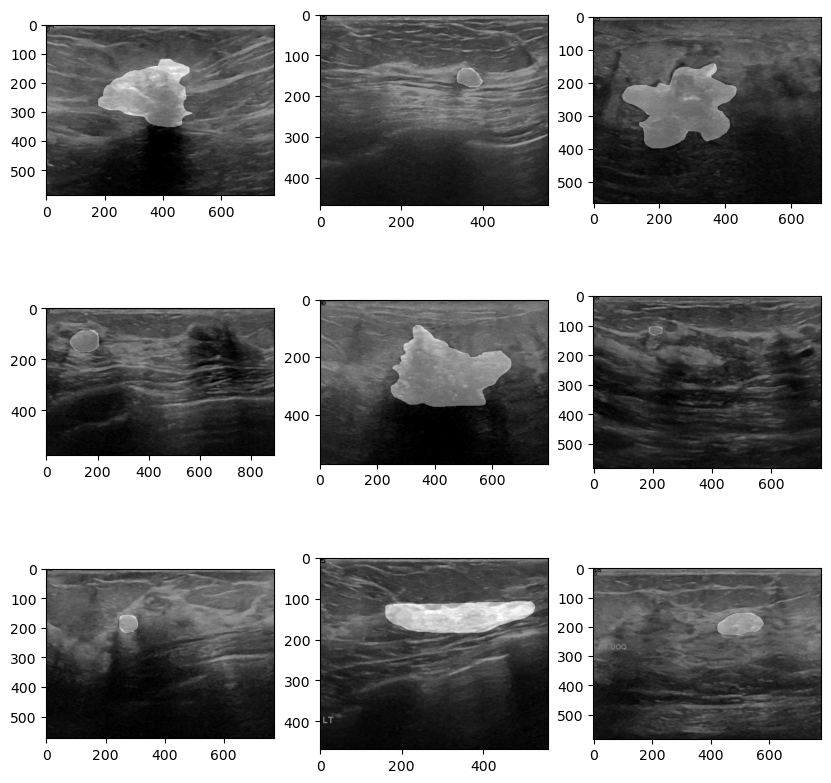

In [5]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    ii = random.randint(0, len(df_train1))
    fig.add_subplot(rows,cols,i)
    img_path1=df_train1['image'][ii]
    msk_path1=df_train1['mask'][ii]
    plt.imshow(np.array(Image.open(img_path1)), cmap = 'gray')
    plt.imshow(np.array(Image.open(msk_path1).convert('1')),alpha=0.4, cmap = 'gray')
plt.show()



In [6]:
# rows,cols=3,3
# fig=plt.figure(figsize=(10,10))
# for i in range(1,rows*cols+1):
#     ii = random.randint(0, len(df_train2))
#     fig.add_subplot(rows,cols,i)
#     img_path2=df_train2['image'][ii]
#     msk_path2=df_train2['mask'][ii]
#     plt.imshow(np.array(Image.open(img_path2)), cmap = 'gray')
#     plt.imshow(np.array(Image.open(msk_path2).convert('1')),alpha=0.4, cmap = 'gray')
# plt.show()


In [7]:
def rle_encoding(x):
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def convert_to_tensor(x,**kwargs):
    return x.transpose(2,0,1).astype("float32")

def func_for_preprocessing(preprocessing_fn=None):
    transform = []
    if preprocessing_fn:
        transform.append(albumentations.Lambda(image=preprocessing_fn))
    transform.append(albumentations.Lambda(image=convert_to_tensor))
    return albumentations.Compose(transform)

def trainaugs():
    transform =  [
                albumentations.Resize(height=256,width=256,interpolation=Image.BILINEAR),
                    albumentations.OneOf([
                    albumentations.RandomRotate90(p=0.5),
                    albumentations.HorizontalFlip(p=0.5),
                    albumentations.VerticalFlip(p=0.5),
                    albumentations.ShiftScaleRotate(scale_limit=0 , rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
                    ]),
                     albumentations.OneOf([
                    albumentations.OpticalDistortion(p=0.5),
                    albumentations.GridDistortion(p=0.5),
                    albumentations.ElasticTransform(p=0.5),
                ])
                 
            ]
    return albumentations.Compose(transform)

def valaugs():
    transform = [
                albumentations.Resize(height=256,width=256,interpolation=Image.BILINEAR),
            ]
    return albumentations.Compose(transform)


class GetDataset(Dataset):
    def __init__(self,imagespath,maskspath,augment=None,preprocess=None):
        self.imagespath = imagespath
        self.maskspath = maskspath
        self.augment = augment
        self.preprocess = preprocess
        
    def __len__(self):
        return len(self.imagespath)
    
    def __getitem__(self,idx):
        image = cv2.cvtColor(cv2.imread(self.imagespath[idx]),cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskspath[idx], cv2.IMREAD_GRAYSCALE)

        if self.augment:
            sample = self.augment(image=image, mask=mask)
            image,mask = sample['image'],sample['mask']
        if self.preprocess:
            sample = self.preprocess(image=image,mask=mask)
            image,mask = sample['image'],sample['mask']

        mask = (mask / 255).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)
       

        return image,mask

In [8]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)
encoder = "resnet34"
encoder_wts = "imagenet"
activation = "sigmoid"


model = smp.Unet(encoder_name=encoder,activation=activation,encoder_weights=encoder_wts)
preprocess_func = smp.encoders.get_preprocessing_fn(encoder,encoder_wts)


traindata = GetDataset(imagespath = df_train['image'].tolist(),
                            maskspath = df_train['mask'].tolist(),
                            augment = trainaugs(),
                            preprocess = func_for_preprocessing(preprocess_func))

validationdata = GetDataset(imagespath = df_val['image'].tolist(),
                            maskspath = df_val['mask'].tolist(),
                            augment = valaugs(),
                           preprocess = func_for_preprocessing(preprocess_func))

batch_size = 32
trainloader = DataLoader(traindata,batch_size = batch_size,shuffle=True)
valloader = DataLoader(validationdata,batch_size=4,shuffle=False)


In [9]:
trainmodel = True
epochs = 50
device = "cuda"
loss = smp.utils.losses.base.SumOfLosses(smp.utils.losses.BCELoss(),smp.utils.losses.DiceLoss())
metrics = [ smp.utils.metrics.IoU(),
            smp.utils.metrics.Fscore(),
            smp.utils.metrics.Accuracy(),
            smp.utils.metrics.Precision(),
            smp.utils.metrics.Recall(),
 ]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0003)])
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.2)

trainepoch = smp.utils.train.TrainEpoch(model,loss=loss,optimizer=optimizer,metrics=metrics,device=device,verbose=True)
validepoch = smp.utils.train.ValidEpoch(model,loss=loss,metrics=metrics,device=device,verbose=True)

In [10]:
best_iou_score = 0.0 
train_logs_list, valid_logs_list = [], []
for i in range(0,epochs):
    print('\nEpoch: {}'.format(i))
    trainlogs = trainepoch.run(trainloader)
    validlogs = validepoch.run(valloader)
    lr_scheduler.step()

    train_logs_list.append(trainlogs)
    valid_logs_list.append(validlogs)
    if best_iou_score < validlogs['iou_score']:
        best_iou_score = validlogs['iou_score']
        torch.save(model, './best_model/Unet4Lauggray/best_model.pth')


Epoch: 0
valid: 100%|██████████| 33/33 [00:07<00:00,  4.37it/s, bce_loss + dice_loss - 0.7691, iou_score - 0.5036, fscore - 0.6366, accuracy - 0.9465, precision - 0.6888, recall - 0.6543]

Epoch: 1
valid: 100%|██████████| 33/33 [00:07<00:00,  4.57it/s, bce_loss + dice_loss - 0.6136, iou_score - 0.5476, fscore - 0.6836, accuracy - 0.9499, precision - 0.711, recall - 0.7244] 

Epoch: 2
valid: 100%|██████████| 33/33 [00:06<00:00,  5.12it/s, bce_loss + dice_loss - 0.5513, iou_score - 0.5683, fscore - 0.6999, accuracy - 0.9528, precision - 0.7477, recall - 0.7314]

Epoch: 3
valid: 100%|██████████| 33/33 [00:08<00:00,  4.11it/s, bce_loss + dice_loss - 0.5021, iou_score - 0.5965, fscore - 0.7213, accuracy - 0.9577, precision - 0.7919, recall - 0.7197]

Epoch: 4
valid: 100%|██████████| 33/33 [00:05<00:00,  5.76it/s, bce_loss + dice_loss - 0.5001, iou_score - 0.5787, fscore - 0.7067, accuracy - 0.9574, precision - 0.8223, recall - 0.6611]

Epoch: 5
valid: 100%|██████████| 33/33 [00:10<00:00,  

In [11]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.to_excel("./best_model/Unet4Lauggray/train.xlsx")
valid_logs_df.to_excel("./best_model/Unet4Lauggray/valid.xlsx")
train_logs_df.T
valid_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
bce_loss + dice_loss,0.769070,0.613641,0.551287,0.502147,0.500073,0.493124,0.443228,0.435411,0.475382,0.495378,...,0.333322,0.333134,0.329796,0.331225,0.347177,0.332910,0.341222,0.334854,0.350796,0.331307
iou_score,0.503593,0.547649,0.568307,0.596501,0.578738,0.567266,0.618094,0.619772,0.594637,0.560529,...,0.692443,0.688918,0.693491,0.695404,0.684066,0.692415,0.689942,0.691259,0.683158,0.690742
fscore,0.636587,0.683587,0.699922,0.721279,0.706741,0.691994,0.737432,0.735540,0.719059,0.679744,...,0.801374,0.798616,0.802377,0.804166,0.794517,0.800582,0.798088,0.800483,0.794653,0.800250
accuracy,0.946547,0.949930,0.952812,0.957710,0.957398,0.958496,0.961108,0.961373,0.957527,0.956126,...,0.967506,0.968353,0.968076,0.967910,0.964026,0.966901,0.965139,0.966171,0.963864,0.967553
precision,0.688786,0.710972,0.747725,0.791881,0.822343,0.871873,0.798333,0.831080,0.814717,0.818992,...,0.812811,0.849348,0.823178,0.826734,0.789914,0.828128,0.812541,0.821130,0.790060,0.835913
recall,0.654314,0.724441,0.731354,0.719698,0.661104,0.630611,0.751367,0.711218,0.686646,0.641629,...,0.813929,0.786977,0.806588,0.809432,0.825624,0.809208,0.816726,0.811820,0.823471,0.797750


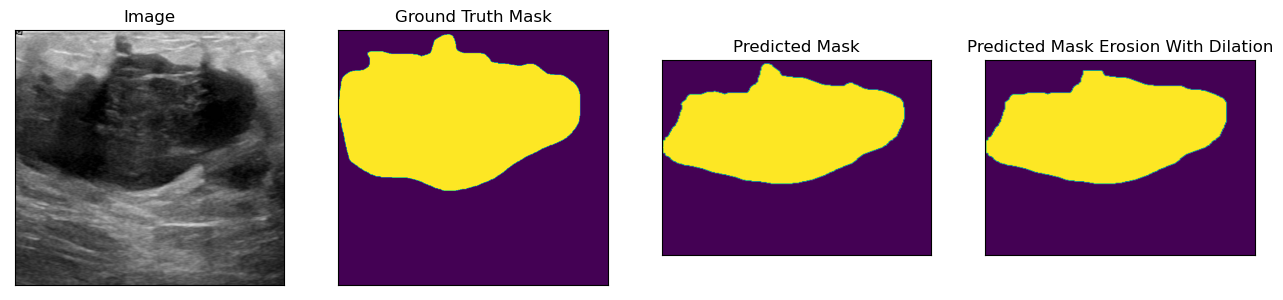

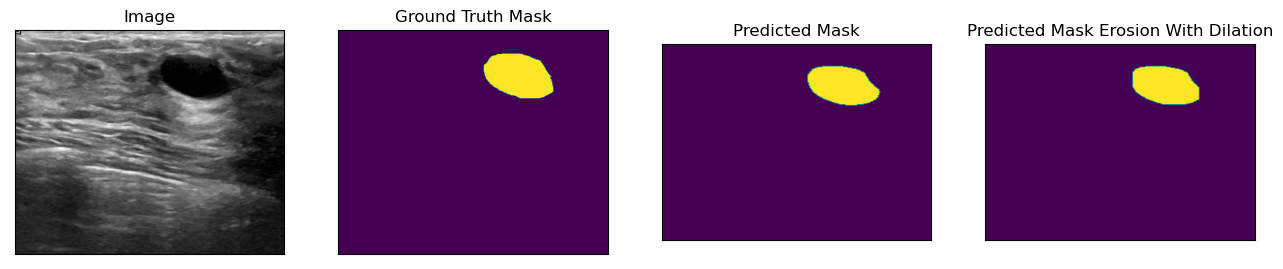

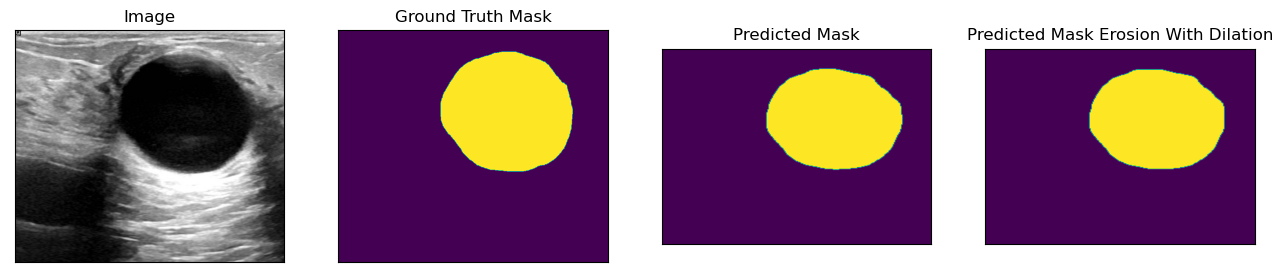

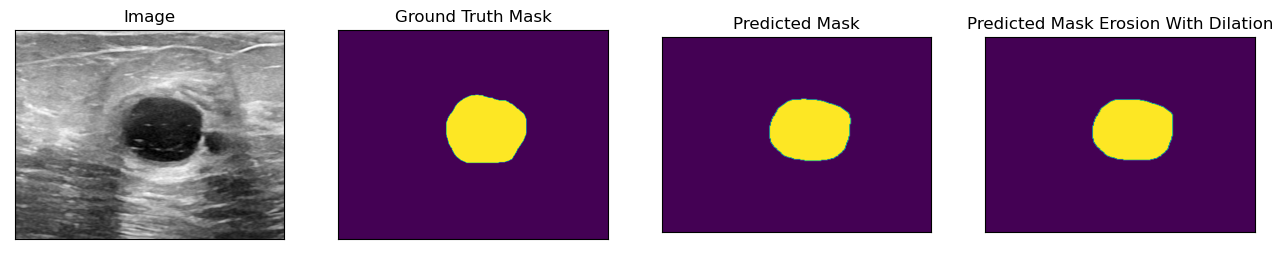

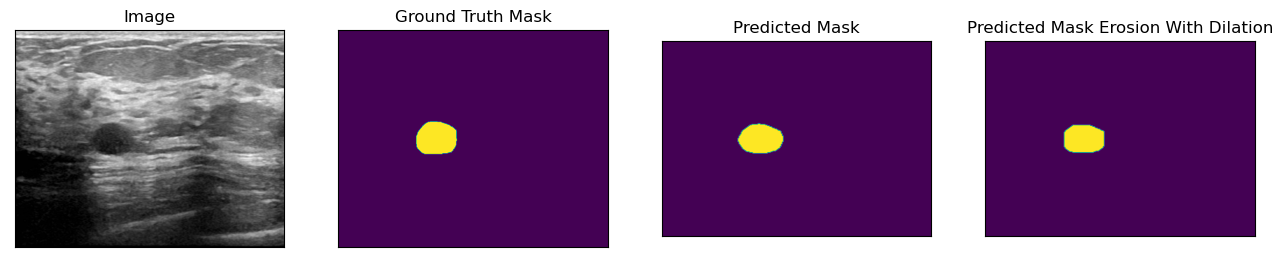

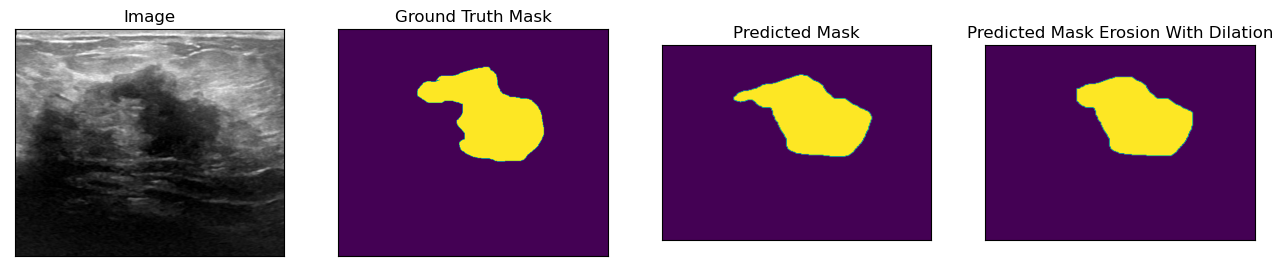

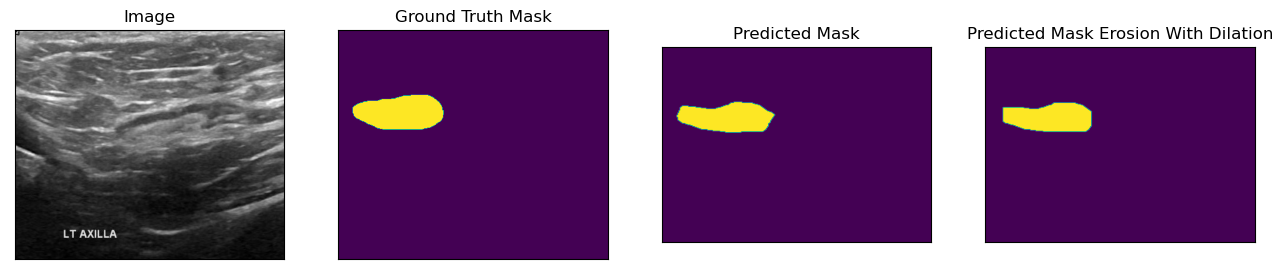

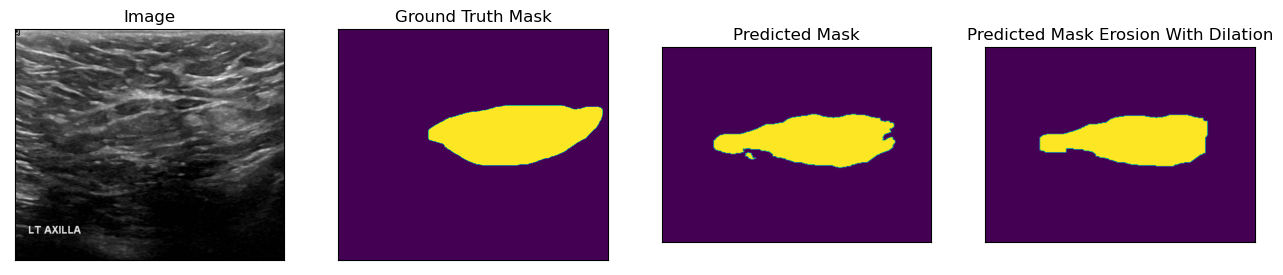

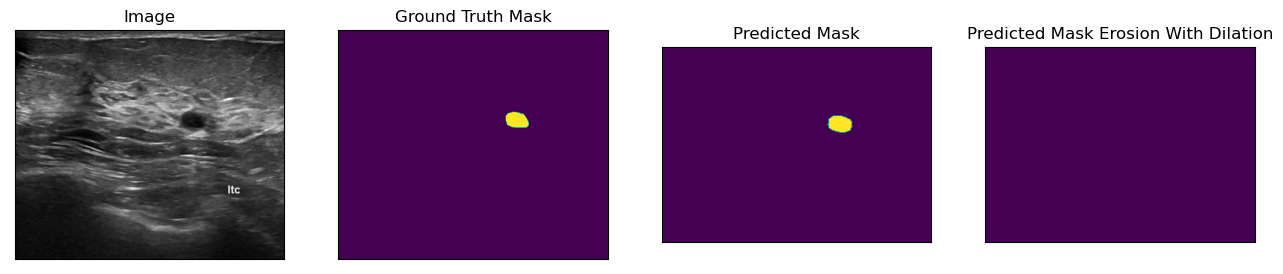

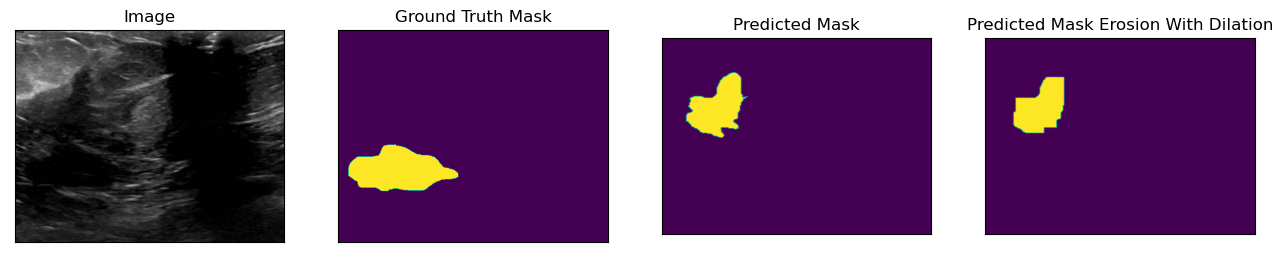

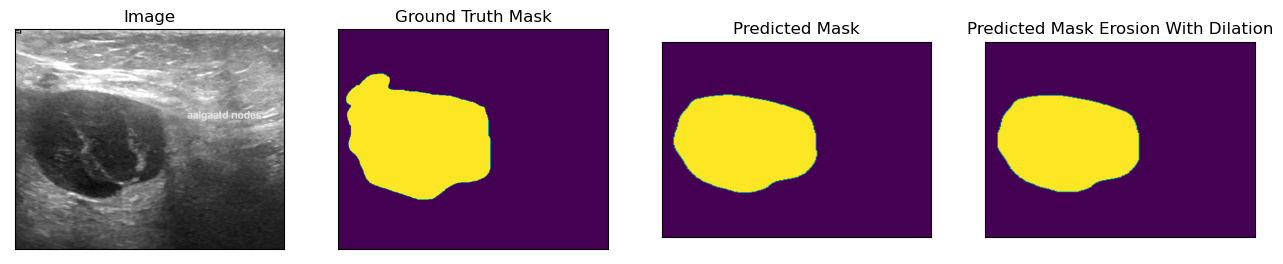

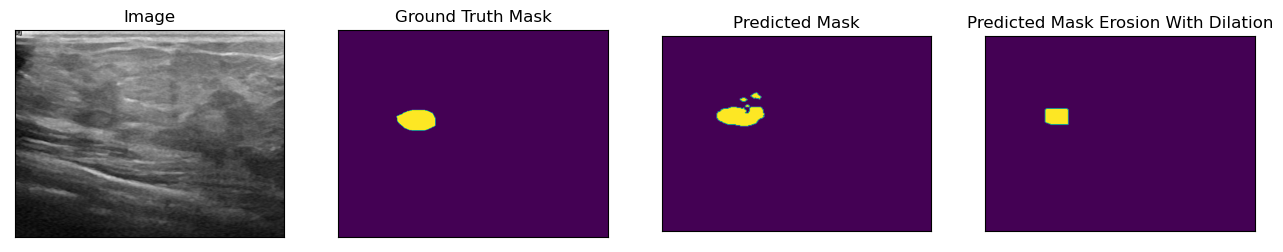

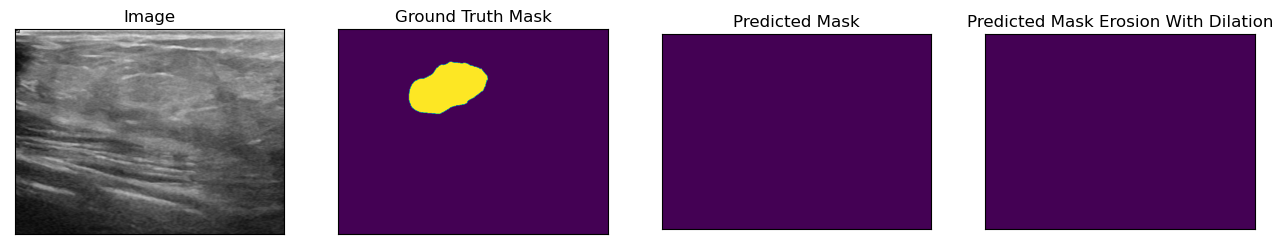

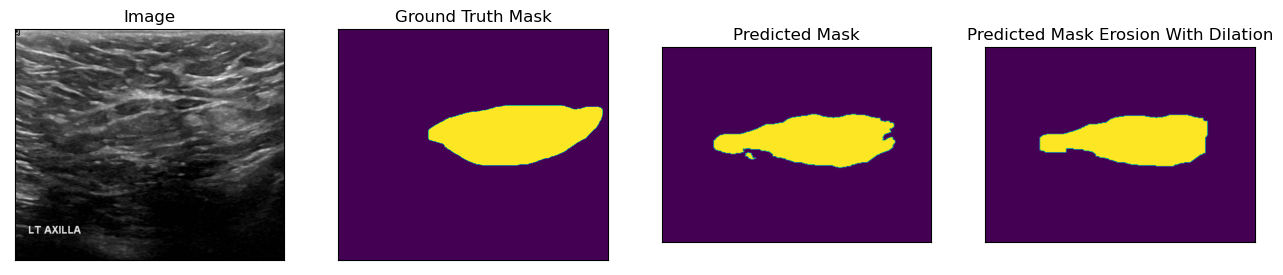

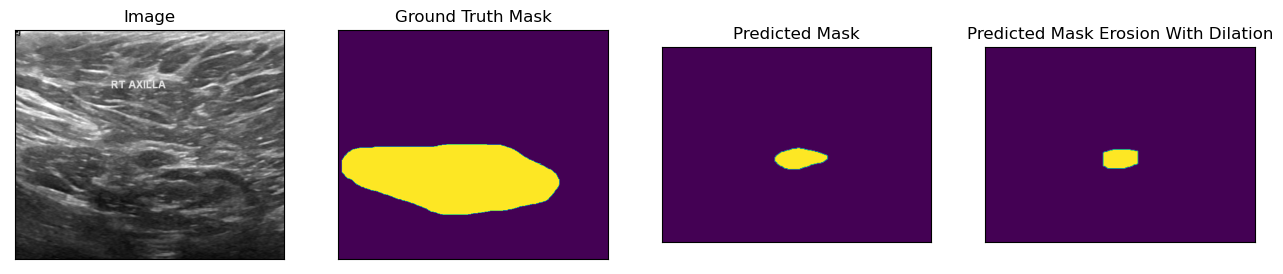

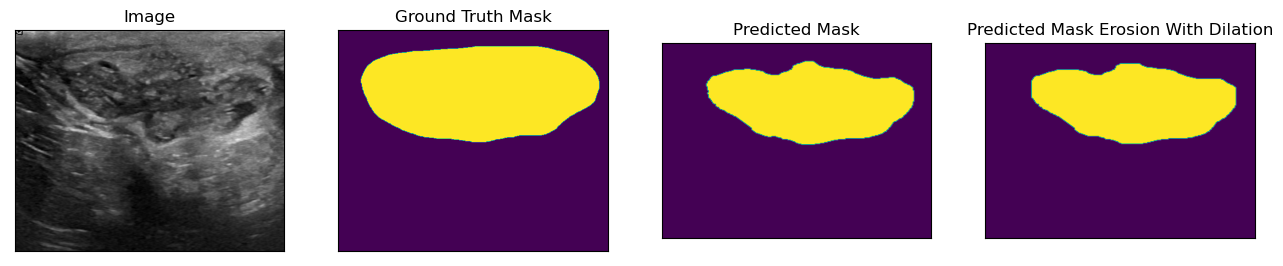

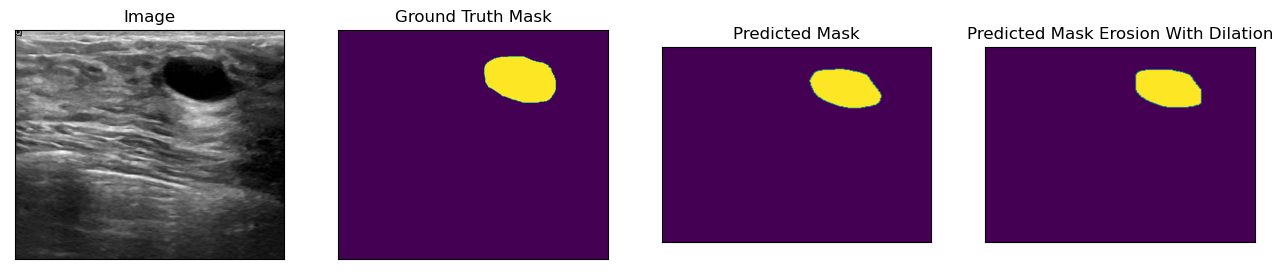

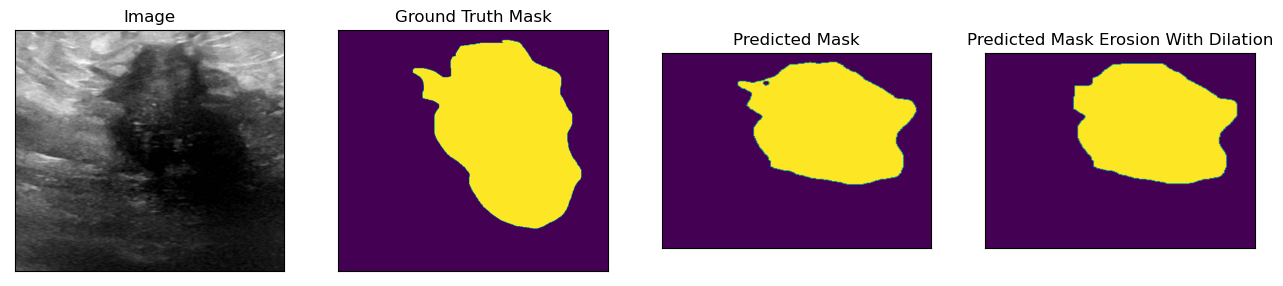

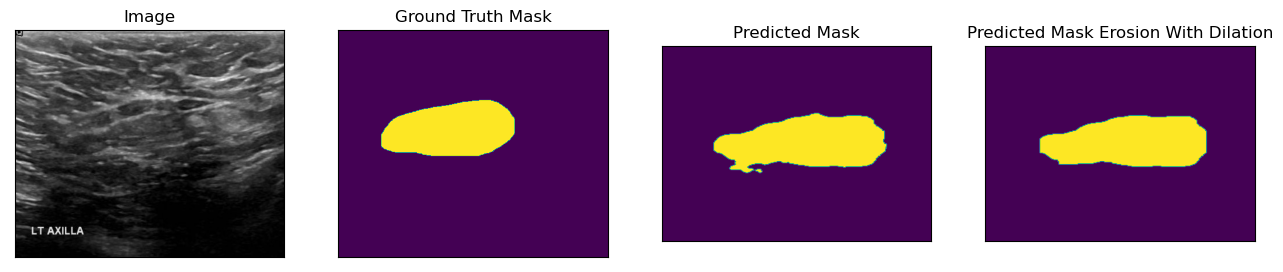

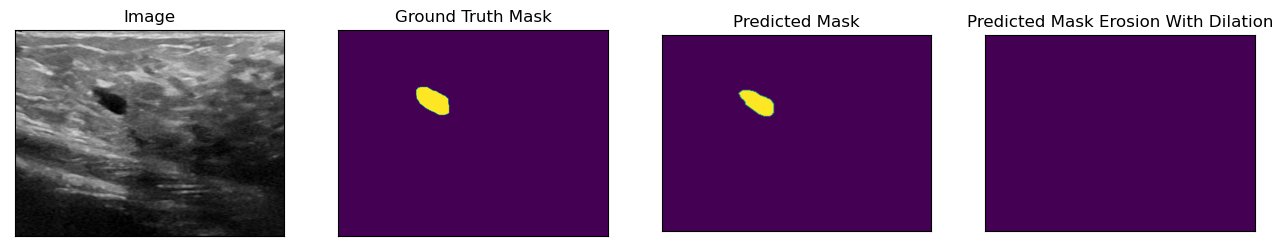

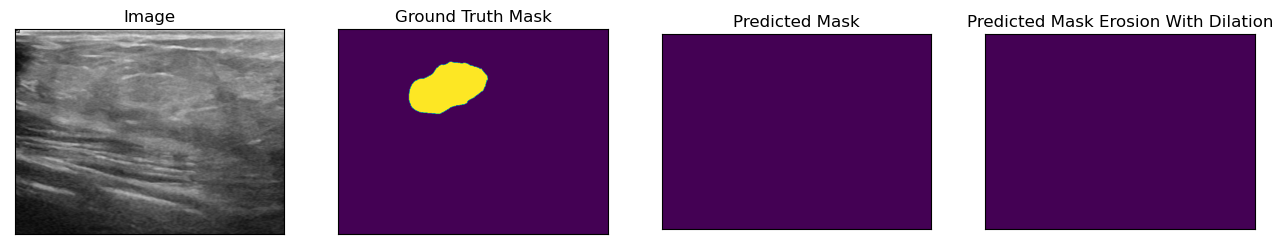

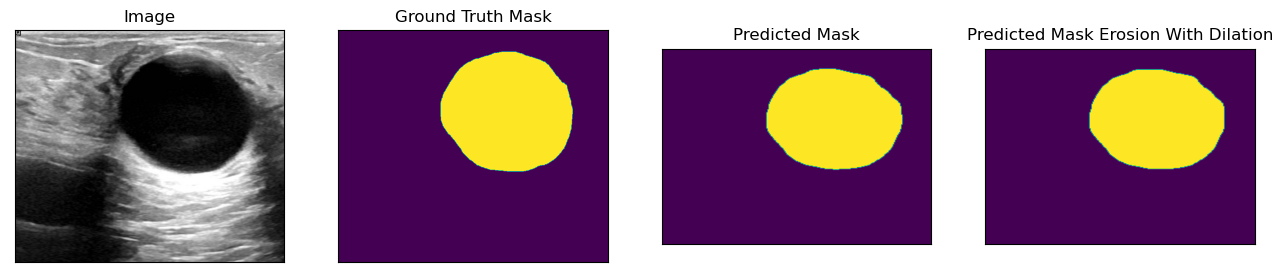

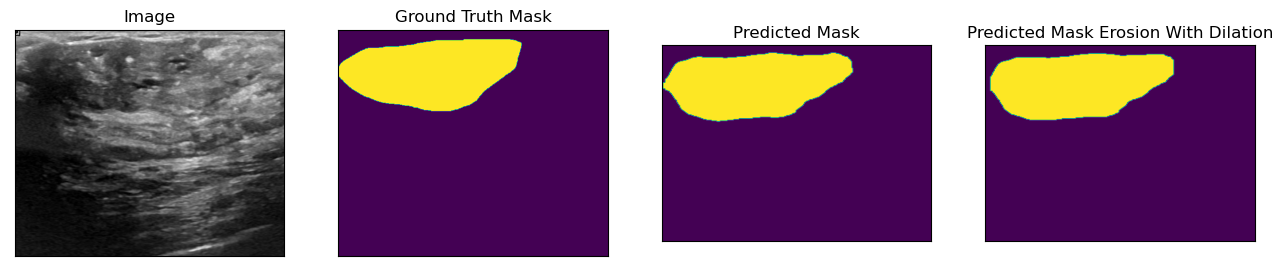

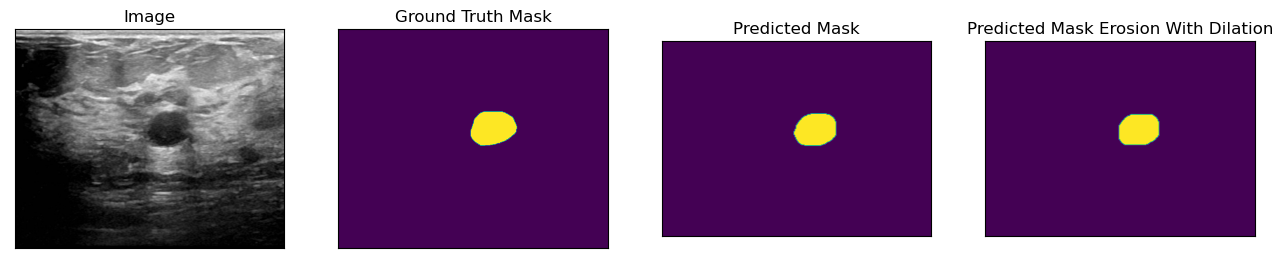

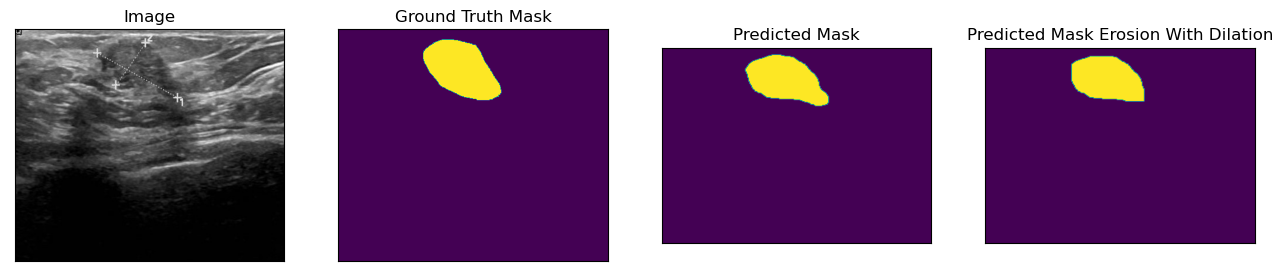

In [12]:
best_model = torch.load('./best_model/Unet4Lauggray/best_model.pth')

test_dataset = GetDataset(imagespath = df_val['image'].tolist(),
                            maskspath = df_val['mask'].tolist(),
                            augment = valaugs(),
                           preprocess = func_for_preprocessing(preprocess_func))


test_dataset_vis = GetDataset(imagespath = df_val['image'].tolist(),
                            maskspath = df_val['mask'].tolist())


def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if image.shape[0] == 3:
            image = image.transpose([1, 2, 0])
        plt.imshow(image)
    plt.show()

for i in range(25):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    mask_vis = test_dataset_vis[n][1].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().numpy().round()

    kernel = np.ones((5,5),np.uint8)
    pr_mask_er = cv2.erode(pr_mask,kernel,iterations = 4)
    pr_mask_er = cv2.dilate(pr_mask_er,kernel,iterations = 4)

    pr_mask = cv2.resize(pr_mask, (580, 420))
    pr_mask_er = cv2.resize(pr_mask_er, (580, 420))

    mask_vis = mask_vis.squeeze()

    visualize(
        image=image_vis, 
        ground_truth_mask=mask_vis, 
        predicted_mask=pr_mask,
        predicted_mask_erosion_with_dilation=pr_mask_er
    )